###Rime TARCHIHI-Final Project DEEP LEARNING

### Introduction


Enzymes are proteins that catalyze biochemical reactions and are classified using the Enzyme Commission (EC) numbering system.
Accurate enzyme classification is essential for understanding protein function.

Recent advances in deep learning and transformer-based models have enabled powerful sequence-based representations.
In this project, we fine-tune ProtBERT, a transformer model pre-trained on millions of protein sequences, to classify enzymes into their top-level EC classes using only amino acid sequences.


### Environment Setup

This cell installs all required libraries used in this project.  
We rely on the HuggingFace for transformer models and datasets,
as well as usual machine learning libraries for evaluation.


- `transformers`: for loading and fine-tuning the ProtBERT model
- `datasets`: for efficient dataset handling
- `evaluate`: for computing evaluation metrics
- `scikit-learn`: for data splitting and metrics
- `accelerate`: for efficient GPU/CPU training
- `sentencepiece`: required for ProtBERT tokenization


In [1]:
!pip install -q transformers datasets evaluate scikit-learn accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
df = pd.read_csv(
    "uniprotkb_reviewed_ec.tsv.gz",
    sep="\t",
    compression="gzip"
)

### Dataset Loading and Inspection

In this step, I load the enzyme dataset obtained from UniProtKB.
The dataset contains protein sequences together with their corresponding EC numbers.
I use the Pandas library to read the tab-separated and gzip-compressed file.
Before preprocessing, I inspect the data to understand its structure and size.


In [4]:
print(df.head())
print(df.columns)
print("Total sequences:", len(df))

        Entry   Entry Name                                           Sequence  \
0  A0A0B4K692   NEP2_DROME  MQTVIQNPNWWRRRNKLEKSLLVSLGIMFVVLATGFGLWIGKVLRT...   
1  A0A0B4K7J2   RBP2_DROME  MFTTRKEVDAHVHKMLGKLQPGRERDIKGLAVARLYMKVQEYPKAI...   
2  A0A0B4KEE4    KOI_DROME  MSENTYQIETRRRSRSKTPFLRSSCDHENCEHAGEEGHVHHLKRKS...   
3  A0A0B4KGY6   NOVA_DROME  MESIMKVAMDKAAEQLIQQFGFDYLQQQLQLQHQNQHNSSPQQPQH...   
4  A0A0B4LFY9  STING_DROME  MAIASNVVEAGNAVRAEKGRKYFYFRKMIGDYIDTSIRIVATVFLA...   

   EC number  
0  3.4.24.11  
1    2.3.2.-  
2        NaN  
3        NaN  
4        NaN  
Index(['Entry', 'Entry Name', 'Sequence', 'EC number'], dtype='object')
Total sequences: 20226


### Dataset overview

I inspect its structure to understand the available information.
The dataset contains the following main columns:

- Entry: Unique UniProt accession identifier for each protein  
- Entry Name: UniProt entry name  
- Sequence: Amino acid sequence of the protein  
- EC number: Enzyme Commission number describing the catalytic function  

The output also shows that some proteins do not have an assigned EC number (NaN values). These correspond to non-enzymatic proteins and will be removed in the next preprocessing step.


In [5]:
# Remove proteins without EC numbers
df = df.dropna(subset=["EC number"])

print("After removing non-enzymes:", len(df))


After removing non-enzymes: 7441


Not all proteins in UniProt are enzymes. Since this project focuses on enzyme classification,
proteins without an assigned EC number are removed from the dataset.

Some proteins are associated with multiple EC numbers. To simplify the classification task,
only the first EC number is retained for each protein.

The EC number has a hierarchical structure (X.X.X.X).  
For this work, only the top-level EC class (the first digit) is used as the prediction target,
corresponding to the seven main enzyme classes:

1. Oxidoreductases  
2. Transferases  
3. Hydrolases  
4. Lyases  
5. Isomerases  
6. Ligases  
7. Translocases  

Finally, the dataset is filtered to retain only valid EC classes (1–7).


In [6]:
# If multiple EC numbers exist, keep the first
df["EC_number"] = df["EC number"].apply(lambda x: x.split(";")[0])

# Extract first EC digit
df["ec_class"] = df["EC_number"].apply(lambda x: x.split(".")[0])

# Keep only valid enzyme classes 1–7
df = df[df["ec_class"].isin([str(i) for i in range(1, 8)])]

print(df["ec_class"].value_counts())


ec_class
2    2705
3    2225
1    1239
4     439
6     383
5     289
7     161
Name: count, dtype: int64


In [7]:
ec_map = {
    "1": "Oxidoreductases",
    "2": "Transferases",
    "3": "Hydrolases",
    "4": "Lyases",
    "5": "Isomerases",
    "6": "Ligases",
    "7": "Translocases"
}

df["label_name"] = df["ec_class"].map(ec_map)
df["label"] = df["ec_class"].astype(int) - 1  # 0–6

df = df[["Sequence", "label", "label_name"]]
df.head()


,Sequence,label,label_name
0,MQTVIQNPNWWRRRNKLEKSLLVSLGIMFVVLATGFGLWIGKVLRT...,2,Hydrolases
1,MFTTRKEVDAHVHKMLGKLQPGRERDIKGLAVARLYMKVQEYPKAI...,1,Transferases
6,MNLTKLMKVFGYINIITNCVQSFTNRADKKRYNVFAKSFINTINTN...,2,Hydrolases
7,MPPRCRRLPLLFILLLAVRPLSAAAASSIAAAPASSYRRISWASNL...,1,Transferases
8,MASPPPFDICGDLDDDPTPPAPTPLAAPTPNGLNDRLLRLTRTHQR...,2,Hydrolases


I mapped the seven top-level EC classes to human readable class names using a predefined dictionary.
For model training, I needed to represent the class labels as integers. Therefore, I converted the EC classes (1–7) into zero-based numerical labels (0–6), which is the required format for multi-class classification in PyTorch and Hugging Face models.

I retained two representations of the labels:

label: the integer-encoded class, used for model training

label_name: the descriptive enzyme class name, used for interpretation and visualization

Finally, I reduced the dataset to the essential columns:

Amino acid sequence

Numerical label

Enzyme class name


###Train, Validation, and Test Split

I split the dataset into three subsets: training, validation, and test sets.
To ensure fair evaluation and preserve class balance, I used stratified sampling based on the enzyme class labels.

Specifically:

70% of the data for training

15% for validation, used to monitor model performance during training

15% for testing, reserved for final evaluation

The split was performed in two steps:

First, I separated the training set from the remaining data.

Then, I split the remaining data equally into validation and test sets.

In [8]:
from sklearn.model_selection import train_test_split
# 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 5208
Validation size: 1116
Test size: 1117


###Sequence Preprocessing for ProtBERT

I preprocessed the protein sequences to match the input format expected by ProtBERT.
Since ProtBERT was trained on protein sequences where each amino acid is treated as a separate token, I inserted spaces between individual amino acids in each sequence.

In [9]:
def space_separate(seq):
    return " ".join(list(seq))

train_df["Sequence"] = train_df["Sequence"].apply(space_separate)
val_df["Sequence"]   = val_df["Sequence"].apply(space_separate)
test_df["Sequence"]  = test_df["Sequence"].apply(space_separate)



###Model and Tokenizer Initialization

I initialized ProtBERT, using the Hugging Face Transformers library.

The AutoTokenizer is used to convert amino acid sequences into token IDs compatible with ProtBERT. Lowercasing is disabled because protein sequences are case-sensitive and amino acids are represented by uppercase letters.

For the classification task, I loaded AutoModelForSequenceClassification and configured the model with 7 output labels, corresponding to the seven top-level Enzyme Commission EC classes.

Finally, the model is moved to a GPU if available, otherwise it runs on the CPU, ensuring efficient training when hardware acceleration is available.

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
MODEL_NAME = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    do_lower_case=False
)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=7
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("on", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


on cuda


The model was successfully loaded from Hugging Face. Since ProtBERT is a pretrained language model, its backbone weights were reused, while the final classification layer was newly initialized to adapt the model to the 7 enzyme classes. This layer is trained during fine-tuning. The model was loaded and executed on a GPU (CUDA).

In [13]:
def tokenize(batch):
    return tokenizer(
        batch["Sequence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

###Tokenization and Dataset Preparation

Protein sequences were tokenized using the ProtBERT tokenizer. Each amino acid sequence was converted into tokens with padding and truncation applied to a maximum length of 512 tokens. The training and validation data were then converted into Hugging Face Dataset objects, tokenized in batches, and formatted as PyTorch tensors. Non-essential columns (raw sequences and label names) were removed to prepare the datasets for efficient model training.

In [14]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["Sequence", "label_name"])
val_dataset = val_dataset.remove_columns(["Sequence", "label_name"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/5208 [00:00<?, ? examples/s]

Map:   0%|          | 0/1116 [00:00<?, ? examples/s]

##Test Dataset Preparation
I prepared the test dataset by converting it into a Hugging Face Dataset object. I applied the same tokenization process used for the training and validation sets to ensure consistency. The protein sequences were padded and truncated to a fixed length, unnecessary columns were removed, and the data was formatted as PyTorch tensors for efficient evaluation after training.

In [15]:
#test dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.remove_columns(["Sequence", "label_name"])
test_dataset.set_format("torch")


Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./protbert_ec",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

I defined the training configuration using the Hugging Face TrainingArguments class. I trained the model for three epochs with a learning rate of 2e-5 and a batch size of 4. Model evaluation and checkpoint saving were performed at the end of each epoch. I selected the best model based on validation accuracy and enabled mixed-precision (FP16) training when a GPU was available to improve performance.

After training the ProtBERT model, I evaluate its performance using standard classification metrics.
Accuracy alone is not always sufficient, especially in multi-class problems with class imbalance, such as enzyme classification.

Therefore, I compute additional metrics to better understand the model’s behavior across all enzyme classes:

Accuracy: measures the overall proportion of correctly classified sequences.

Precision: evaluates how many of the predicted enzyme classes are correct.

Recall: measures how well the model identifies all instances of each enzyme class.

F1-score: provides a balanced measure between precision and recall.

All metrics are computed using a weighted average, which takes into account the class distribution and ensures that larger classes do not dominate the evaluation unfairly.

The following function defines these evaluation metrics and is used by the Hugging Face Trainer during validation and testing.

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


###Evaluation Metric
I defined an evaluation function to measure model performance using classification accuracy. During evaluation, I converted the model’s output logits into predicted class labels using argmax and compared them with the true labels. The accuracy score was then computed and returned to monitor model performance during validation and training.

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-293716929.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


###Trainer Setup

After defining the model architecture, training arguments, and evaluation metrics, I train the ProtBERT model using the Hugging Face Trainer API.

The model is fine-tuned on the training set for 3 epochs, while performance is monitored on the validation set at the end of each epoch.
During training, the framework automatically reports:

Training loss

Validation loss

Accuracy

Precision

Recall

F1-score

This allows me to track both optimization progress and generalization performance over time.

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.874300,0.712859,0.793907,0.779327,0.793907,0.771268
2,0.317900,0.581317,0.861111,0.867967,0.861111,0.858107
3,0.348100,0.494214,0.893369,0.896536,0.893369,0.893761


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=3906, training_loss=0.5777749984739258, metrics={'train_runtime': 2643.7921, 'train_samples_per_second': 5.91, 'train_steps_per_second': 1.477, 'total_flos': 1.8188221943291904e+16, 'train_loss': 0.5777749984739258, 'epoch': 3.0})

The training results show a consistent improvement across epochs:

Training loss decreases significantly, indicating that the model is learning meaningful patterns from protein sequences.

Validation loss steadily decreases and does not diverge from training loss, suggesting no strong overfitting.

Accuracy improves from approximately 79% in the first epoch to ~89% by the third epoch.

Precision, recall, and F1-score all increase across epochs, confirming that the model improves not only overall correctness but also class-level prediction quality.

The final epoch achieves:

Validation Accuracy ≈ 89.3%

Validation F1-score ≈ 0.894

This indicates that ProtBERT is able to effectively capture enzyme-specific sequence features and generalize well to unseen validation data.

In [20]:
trainer.evaluate()

{'eval_loss': 0.49421370029449463,
 'eval_accuracy': 0.8933691756272402,
 'eval_precision': 0.8965362131355358,
 'eval_recall': 0.8933691756272402,
 'eval_f1': 0.8937610405614278,
 'eval_runtime': 34.5459,
 'eval_samples_per_second': 32.305,
 'eval_steps_per_second': 8.076,
 'epoch': 3.0}

After training, I evaluate the model on the validation set to measure its performance on unseen data and assess generalization.

The evaluation results are:

Validation Accuracy: ~89.34%

Precision (weighted): ~89.65%

Recall (weighted): ~89.34%

F1-score (weighted): ~89.38%

Validation Loss: ~0.49

These results indicate that the model maintains strong and balanced performance across all enzyme classes.
The close values of precision, recall, and F1-score suggest that the model does not favor specific classes and handles class imbalance reasonably well.

Overall, the validation performance confirms that the model generalizes well and is not overfitting to the training data, making it suitable for final evaluation on the test set.

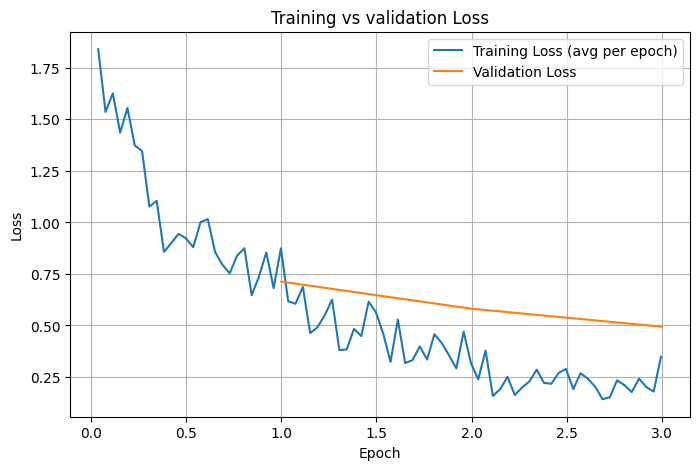

In [21]:
import matplotlib.pyplot as plt
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
train_epoch = df_logs[df_logs["loss"].notna() & df_logs["epoch"].notna()].groupby("epoch")["loss"].mean().reset_index()
eval_epoch  = df_logs[df_logs["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8,5))
plt.plot(train_epoch["epoch"], train_epoch["loss"], label="Training Loss (avg per epoch)")
plt.plot(eval_epoch["epoch"], eval_epoch["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Training vs validation Loss")
plt.legend()
plt.grid(True)
plt.show()


The figure above shows the evolution of the training and validation loss across epochs.
The training loss decreases rapidly during the first epoch and continues to decline steadily, indicating that the model is learning meaningful representations from the protein sequences.

The validation loss also decreases across epochs and follows a similar trend to the training loss. The gap between training and validation loss remains relatively small, which suggests that the model generalizes well to unseen data.

Importantly, there is no significant increase in validation loss in later epochs, indicating no strong signs of overfitting. This behavior confirms that the chosen training setup and number of epochs are appropriate for this task.

<Figure size 800x600 with 0 Axes>

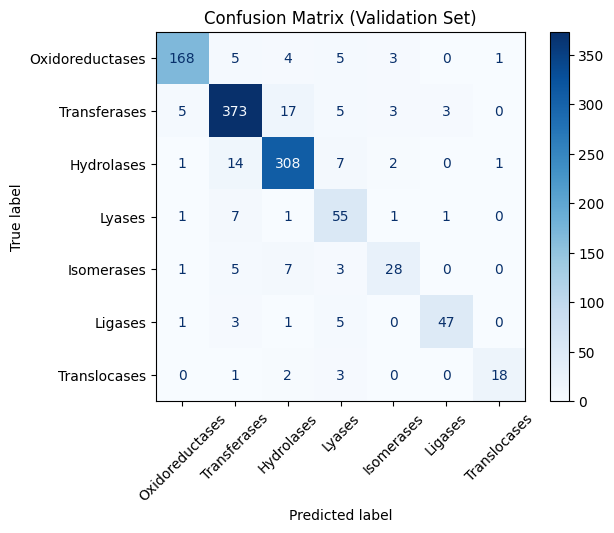

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get predictions on the validation set
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
class_names = [
    "Oxidoreductases",
    "Transferases",
    "Hydrolases",
    "Lyases",
    "Isomerases",
    "Ligases",
    "Translocases"
]
cm = confusion_matrix(y_true, y_pred)#confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()


To better understand the model’s classification behavior beyond overall metrics, I included a confusion matrix for the validation set. This visualization allows me to analyze how predictions are distributed across enzyme classes and to identify which classes are most frequently confused.

From the confusion matrix, most predictions lie along the diagonal, indicating that the majority of enzyme sequences are classified correctly. This confirms the strong performance observed in the quantitative metrics. The model performs particularly well for high-frequency classes such as Transferases and Hydrolases.

Some minor misclassifications occur between related enzyme classes, which may be due to structural or functional similarities between proteins in those categories. However, these errors remain limited and do not significantly affect overall performance.

Overall, the confusion matrix shows that the model not only achieves high accuracy but also maintains balanced performance across different enzyme classes.

In [23]:
test_metrics = trainer.evaluate(test_dataset)
test_metrics

{'eval_loss': 0.3625546395778656,
 'eval_accuracy': 0.9149507609668756,
 'eval_precision': 0.9213789482918496,
 'eval_recall': 0.9149507609668756,
 'eval_f1': 0.9168079118106194,
 'eval_runtime': 35.3619,
 'eval_samples_per_second': 31.588,
 'eval_steps_per_second': 7.918,
 'epoch': 3.0}

<Figure size 800x600 with 0 Axes>

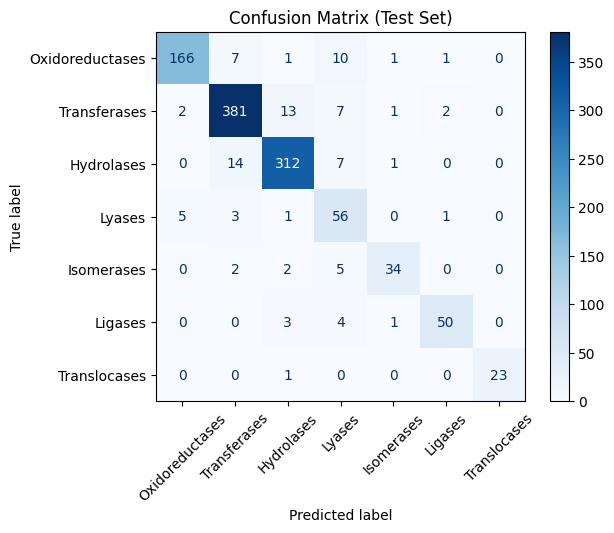

In [25]:
preds_test = trainer.predict(test_dataset)
y_true_test = preds_test.label_ids
y_pred_test = np.argmax(preds_test.predictions, axis=1)
class_names = [
    "Oxidoreductases",
    "Transferases",
    "Hydrolases",
    "Lyases",
    "Isomerases",
    "Ligases",
    "Translocases"
]
cm_test = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=class_names
)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.show()



I also included a confusion matrix for the test set to evaluate how well the model generalizes to completely unseen protein sequences. Similar to the validation results, the test confusion matrix shows strong diagonal dominance, indicating that most enzymes are classified into their correct EC classes.

The model achieves particularly high performance for frequent enzyme classes such as Transferases, Hydrolases, and Ligases, while smaller classes such as Translocases are still classified correctly in most cases despite having fewer samples. This demonstrates that the model generalizes well across both dominant and underrepresented classes.

Only a small number of misclassifications are observed, mainly between enzyme classes with related biochemical functions. These errors are expected and remain limited, confirming that the learned representations are robust.

Overall, the test confusion matrix confirms that the fine-tuned ProtBERT model maintains strong and consistent performance on unseen data, supporting the reliability of the proposed approach.